In [15]:
from imports import *  

In [16]:
# Get the new HST catalogue 
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'
table = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue.fits' %root_dir)

# Get the Barnes et al. 2021 catalogue
table_b21 = QTable.read('/Users/abarnes/Dropbox/work/Projects/pressures/phangs/data/catalouge/v2/physprops/master.fits') 
for key in table_b21.keys():
    if key == 'region_ID' or key == 'gal_name':
        continue
    table_b21.rename_column(key, key+'_MUSE_B21')
table_all = join(table, table_b21, keys=['region_ID', 'gal_name'])

# Get the full muse catalogue
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'
table_muse = QTable.read('%s/data_misc/Nebulae_catalogue_v3/Nebulae_catalogue_v3.fits' %root_dir) 

# GET ELECTRON DENSITY

In [17]:
# Function to produce the SII ratio limit vs. temperature function using pyneb... 
# This slightly differs from the one in the Barnes et al. 2021 paper... 
def get_sii_ratio_ll_func(sii_array = np.linspace(1.39, 1.51, 200), t_array = np.linspace(5000, 20000, 10), showplot=False):

    from scipy.interpolate import CubicSpline

    sii_max = np.empty(len(t_array))
    S2 = pn.Atom('S', 2)
    
    for i, t in enumerate(t_array):
        ne = S2.getTemDen(sii_array, tem=t, wave1=6716, wave2=6730)
        if showplot:
            plt.plot(sii_array, ne, label='%0.0f K' %t)
            plt.legend()
        mask = np.where(ne == 1)[0][0]
        sii_max[i] = sii_array[mask]  

    spl = CubicSpline(t_array, sii_max)

    return(spl)

sii_ratio_ll_func = get_sii_ratio_ll_func()

In [18]:
# Simple Gaussian function
def func(x, a, b):
    return a * np.exp(-0.5 * x**2 / b**2)

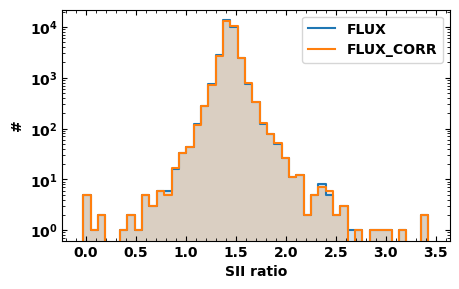

In [19]:
# Comparison of flux ratio to check effect of extinction correction

sii1_corr = table_muse['SII6716_FLUX_CORR'].value
sii2_corr = table_muse['SII6730_FLUX_CORR'].value
sii1_corr_err = table_muse['SII6716_FLUX_CORR_ERR'].value
sii2_corr_err = table_muse['SII6730_FLUX_CORR_ERR'].value

sii1 = table_muse['SII6716_FLUX'].value
sii2 = table_muse['SII6730_FLUX'].value
sii1_err = table_muse['SII6716_FLUX_ERR'].value
sii2_err = table_muse['SII6730_FLUX_ERR'].value

bins = np.linspace(-0.1, 3.5, 50)
bins1, bins_cent1, hist1 = get_hist(sii1/sii2, bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(sii1_corr/sii2_corr, bins=bins, norm=False)

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)

ax.plot(bins_cent1, hist1, ds='steps-mid', label='FLUX')
ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid')

ax.plot(bins_cent2, hist2, ds='steps-mid', label='FLUX_CORR')
ax.fill_between(bins_cent2, hist2, alpha=0.2, step='mid')

ax.set_yscale('log')

ax.set_xlabel("SII ratio")
ax.set_ylabel("#")

ax.legend()

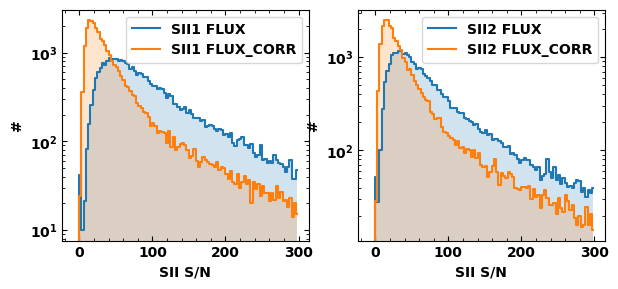

In [20]:
# Comparison of flux S/N to check effect of extinction correction

sii1 = table_muse['SII6716_FLUX'].value
sii2 = table_muse['SII6730_FLUX'].value
sii1_corr = table_muse['SII6716_FLUX_CORR'].value
sii2_corr = table_muse['SII6730_FLUX_CORR'].value

sii1_err = table_muse['SII6716_FLUX_ERR'].value
sii2_err = table_muse['SII6730_FLUX_ERR'].value
sii1_corr_err = table_muse['SII6716_FLUX_CORR_ERR'].value
sii2_corr_err = table_muse['SII6730_FLUX_CORR_ERR'].value

bins = np.linspace(-10, 300, 100)
bins1, bins_cent1, hist1 = get_hist(sii1/sii1_err, bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(sii1_corr/sii1_corr_err, bins=bins, norm=False)
bins3, bins_cent3, hist3 = get_hist(sii2/sii2_err, bins=bins, norm=False)
bins4, bins_cent4, hist4 = get_hist(sii2_corr/sii2_corr_err, bins=bins, norm=False)

fig = plt.figure(figsize=(7, 3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(bins_cent1, hist1, ds='steps-mid', label='SII1 FLUX')
ax1.plot(bins_cent2, hist2, ds='steps-mid', label='SII1 FLUX_CORR')
ax2.plot(bins_cent3, hist3, ds='steps-mid', label='SII2 FLUX')
ax2.plot(bins_cent4, hist4, ds='steps-mid', label='SII2 FLUX_CORR')

ax1.fill_between(bins_cent1, hist1, alpha=0.2, step='mid')
ax1.fill_between(bins_cent2, hist2, alpha=0.2, step='mid')
ax2.fill_between(bins_cent3, hist3, alpha=0.2, step='mid')
ax2.fill_between(bins_cent4, hist4, alpha=0.2, step='mid')

for ax in [ax1,ax2]:

    ax.set_yscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("SII S/N")
    ax.set_ylabel("#")
    ax.legend()

Error correction factor [SII]: 0.679


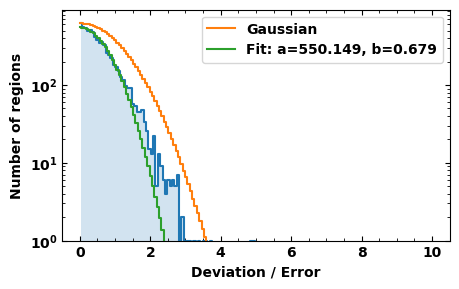

In [21]:
# Get SII error correction factor from all MUSE data (need for statistics)
# Using corrected data - this is not what we want to do... 
# The corrected data include the errors from extinction correction, which we do not want to correct for...

sii1 = table_muse['SII6716_FLUX_CORR'].value
sii2 = table_muse['SII6730_FLUX_CORR'].value
sii1_err = table_muse['SII6716_FLUX_CORR_ERR'].value
sii2_err = table_muse['SII6730_FLUX_CORR_ERR'].value
t_n2 = table_muse['t_N2'].value
t_n2[t_n2.mask] = 8000 

isHII = table_muse['HII_class_v3'] == 1
mask = (sii1 > 0) & (sii2 > 0) & isHII

sii_ratio = sii1 / sii2
sii_ratio_err = sii_ratio * np.sqrt((sii1_err / sii1)**2 + (sii2_err / sii2)**2)
sii_ratio_ll = sii_ratio_ll_func(t_n2)

sii_ratio_lldiff = sii_ratio - sii_ratio_ll 
sii_ratio_lldifferr = sii_ratio_lldiff / sii_ratio_err

sii_ratio = sii_ratio[mask]
sii_ratio_err = sii_ratio_err[mask]
sii_ratio_lldiff = sii_ratio_lldiff[mask]
sii_ratio_lldifferr = sii_ratio_lldifferr[mask]

bins = np.linspace(0, 10, 150)
bins1, bins_cent1, hist1 = get_hist(sii_ratio_lldifferr[sii_ratio_lldifferr >= 0], bins=bins, norm=False)
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
ax.plot(bins_cent1, hist1, ds='steps-mid')
ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid')

ax.plot(bins, func(bins, np.nanmax(hist1), 1), ds='steps-mid', label='Gaussian')

ax.set_yscale('log')
ax.set_ylim(1.0, np.nanmax(hist1)*1.5)

popt, pcov = curve_fit(func, bins_cent1, hist1, p0=[np.nanmax(hist1), 1])
ax.plot(bins, func(bins, *popt), ds='steps-mid', label='Fit: a=%5.3f, b=%5.3f' %tuple(popt))

ax.legend()

ax.set_xlabel("Deviation / Error")
ax.set_ylabel("Number of regions")

error_factor = popt[1]
print('Error correction factor [SII]: %0.3f' %error_factor)

Error correction factor [SII]: 1.530


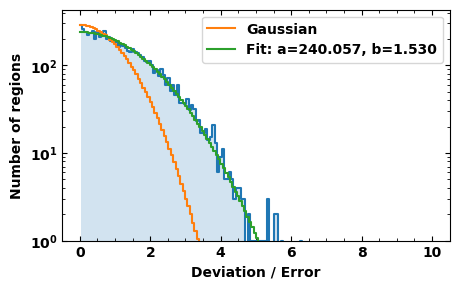

In [22]:
# Get SII error correction factor from all MUSE data (need for statistics)

sii1 = table_muse['SII6716_FLUX'].value
sii2 = table_muse['SII6730_FLUX'].value
sii1_err = table_muse['SII6716_FLUX_ERR'].value
sii2_err = table_muse['SII6730_FLUX_ERR'].value
t_n2 = table_muse['t_N2'].value
t_n2[t_n2.mask] = 8000 

isHII = table_muse['HII_class_v3'] == 1
mask = (sii1 > 0) & (sii2 > 0) & isHII

sii_ratio = sii1 / sii2
sii_ratio_err = sii_ratio * np.sqrt((sii1_err / sii1)**2 + (sii2_err / sii2)**2)
sii_ratio_ll = sii_ratio_ll_func(t_n2)
# sii_ratio_ll = 1.48922887 - 3.94351016e-6 * t_n2 # Don't know where this comes from... 
# sii_ratio_ll = 1.4484 # Sanders et al (2016, ApJ, 816, 23)

sii_ratio_lldiff = sii_ratio - sii_ratio_ll 
sii_ratio_lldifferr = sii_ratio_lldiff / sii_ratio_err

sii_ratio = sii_ratio[mask]
sii_ratio_err = sii_ratio_err[mask]
sii_ratio_lldiff = sii_ratio_lldiff[mask]
sii_ratio_lldifferr = sii_ratio_lldifferr[mask]

bins = np.linspace(0, 10, 150)
bins1, bins_cent1, hist1 = get_hist(sii_ratio_lldifferr[sii_ratio_lldifferr >= 0], bins=bins, norm=False)
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
ax.plot(bins_cent1, hist1, ds='steps-mid')
ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid')

ax.plot(bins, func(bins, np.nanmax(hist1), 1), ds='steps-mid', label='Gaussian')

ax.set_yscale('log')
ax.set_ylim(1.0, np.nanmax(hist1)*1.5)

popt, pcov = curve_fit(func, bins_cent1, hist1, p0=[np.nanmax(hist1), 1])
ax.plot(bins, func(bins, *popt), ds='steps-mid', label='Fit: a=%5.3f, b=%5.3f' %tuple(popt))

ax.legend()

ax.set_xlabel("Deviation / Error")
ax.set_ylabel("Number of regions")

error_factor = popt[1]
print('Error correction factor [SII]: %0.3f' %error_factor)

In [23]:
# Determine the electron density for the SII regions for HST catalogue...

sii1 = table['SII6716_FLUX_MUSE'].value
sii2 = table['SII6730_FLUX_MUSE'].value
sii1_corr = table['SII6716_FLUX_CORR_MUSE'].value 
sii2_corr = table['SII6730_FLUX_CORR_MUSE'].value 

sii1_err = table['SII6716_FLUX_ERR_MUSE'].value * error_factor
sii2_err = table['SII6730_FLUX_ERR_MUSE'].value * error_factor
sii1_corr_err = table['SII6716_FLUX_CORR_ERR_MUSE'].value * error_factor
sii2_corr_err = table['SII6730_FLUX_CORR_ERR_MUSE'].value * error_factor

t_n2 = table['t_N2_MUSE'].value
t_n2[t_n2.mask] = 8000 

isHII = table['HII_class_v3_MUSE'] == True
mask = (sii1 > 0) & (sii2 > 0) & isHII

sii_ratio = sii1 / sii2
sii_corr_ratio = sii1_corr/sii2_corr

sii_ratio_err = sii_ratio * np.sqrt((sii1_err / sii1)**2 + (sii2_err / sii2)**2)
sii_ratio_ll = sii_ratio_ll_func(t_n2)

mask1 = (sii_ratio > 0) 
mask2 = (sii_ratio < sii_ratio_ll - (3*sii_ratio_err))
mask_tot = ((mask1) & (mask2) & (mask))

S2 = pn.Atom('S', 2)
ne = S2.getTemDen(sii_corr_ratio, tem=t_n2, wave1=6716, wave2=6730) # Corrected fluxes here... 
ne_noncorr = S2.getTemDen(sii_ratio, tem=t_n2, wave1=6716, wave2=6730) # Not corrected fluxes here (just to check)... 

table['ne'] = ne * u.cm**-3
table['ne'][~mask_tot] = np.nan # Apply mask.. 

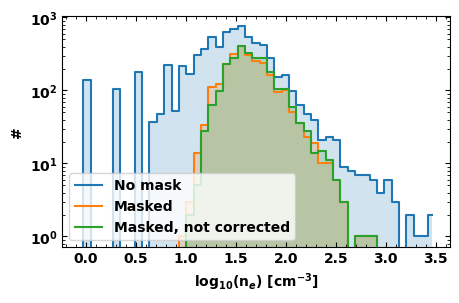

In [24]:
bins = np.linspace(-0.1, 3.5, 50)
bins1, bins_cent1, hist1 = get_hist(np.log10(table['ne'].value), bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(np.log10(ne), bins=bins, norm=False)
bins3, bins_cent3, hist3 = get_hist(np.log10(ne_noncorr[mask_tot]), bins=bins, norm=False)

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)

ax.plot(bins_cent2, hist2, ds='steps-mid', label='No mask')
ax.fill_between(bins_cent2, hist2, alpha=0.2, step='mid')

ax.plot(bins_cent1, hist1, ds='steps-mid', label='Masked')
ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid')

ax.plot(bins_cent3, hist3, ds='steps-mid', label='Masked, not corrected')
ax.fill_between(bins_cent3, hist3, alpha=0.2, step='mid')

ax.set_yscale('log')
ax.set_xlabel("log$_{10}$(n$_e$) [cm$^{-3}$]")
ax.set_ylabel("#")
ax.legend()

# GET IONISATION RATE and Rstrom

Text(0, 0.5, 'Recombination coefficient')

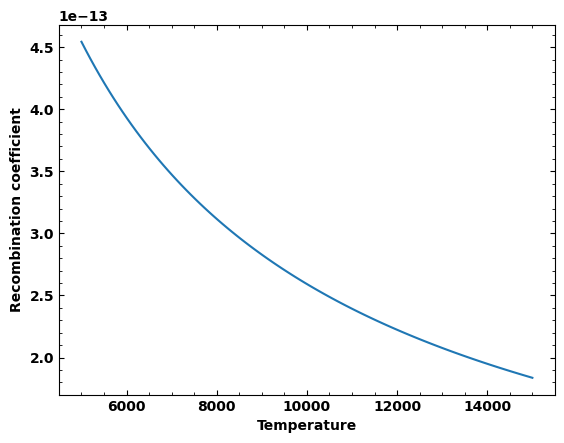

In [25]:
def get_reccoeff(temp):
    alpha = 2.753e-14 * (315614 /  temp)**1.500 / ((1.0 + (115188 / temp)**0.407)**2.242)
    return(alpha*u.cm**3/u.s)

plt.plot(np.linspace(5000,15000,100), get_reccoeff(np.linspace(5000,15000,100)))
plt.xlabel('Temperature')
plt.ylabel('Recombination coefficient')

In [26]:
def get_rstrom(Q, rec_coeff, ne):
    r_strom = ((3/(4*np.pi)) * (Q/(rec_coeff*ne**2)))**(1/3)
    return(r_strom.to('pc'))

def get_nstrom(Q, rec_coeff, r):
    n_strom = ((3/(4*np.pi)) * (Q/(rec_coeff*r**3)))**(1/2)
    return(n_strom.to('1/cm^3'))

radius_circ_pc = table['radius_circ_pc']
radius_mom_pc = table['mean_sigma_pc']
radius_circ_muse = table['region_circ_rad_pc_MUSE']

ha_lum = table['HA6562_LUMINOSITY_HST']
t_n2 = table['t_N2_MUSE'].value
t_n2[t_n2.mask] = 8000 

ha_photon_energy = (1.89 *u.eV).to('erg')   # Energy in erg of single H-alpha photon (https://en.wikipedia.org/wiki/Balmer_series)
ha_rate = ha_lum / ha_photon_energy         # Emission rate (in photons per s) of H-alpha
Q = ha_rate / 0.45                          # Per Calzetti (2012), ~45% of recombinations result in emission of an H-alpha photon

rec_coeff = get_reccoeff(t_n2) # Recombination 
radius_strom_pc = get_rstrom(Q, rec_coeff, table['ne']) # Stromgren Radius

ne_strom_circ = get_nstrom(Q, rec_coeff, radius_circ_pc) # Stromgren Density - Circ HST
ne_strom_mom = get_nstrom(Q, rec_coeff, radius_mom_pc)  # Stromgren Density - Mom HST
ne_strom_circ_muse = get_nstrom(Q, rec_coeff, radius_circ_muse) # Stromgren Density - Circ MUSE

table['rec_coeff'] = rec_coeff
table['Q'] = Q
table['radius_strom_pc'] = radius_strom_pc
table['ne_strom_circ'] = ne_strom_circ
table['ne_strom_mom'] = ne_strom_mom
table['ne_strom_circ_muse'] = ne_strom_circ_muse

In [27]:
table.write('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue_wprops.fits' %root_dir, overwrite=True)

In [28]:
table

gal_name,region_ID,x_max,y_max,x_com,y_com,ra_max,dec_max,ra_com,dec_com,npix,HA6562_FLUX_HST,HA6562_FLUX_ERR_HST,area_exact,radius_circ,flux_max,flux_min,flux_mean,radius_circ_pc,x_mom,y_mom,ra_mom,dec_mom,area_ellipse,major_sigma,minor_sigma,mean_sigma,position_angle,mean_sigma_pc,complexity_score,complexity_score_leaves,complexity_rms,complexity_std,flag_edge_hst,flag_touch_hst,cen_x_MUSE,cen_y_MUSE,cen_ra_MUSE,cen_dec_MUSE,cen_x_geo_MUSE,cen_y_geo_MUSE,flag_edge_MUSE,flag_nearby_MUSE,flag_star_MUSE,deproj_dist_MUSE,deproj_phi_MUSE,region_area_MUSE,region_circ_rad_MUSE,HB4861_FLUX_MUSE,OIII5006_FLUX_MUSE,HA6562_FLUX_MUSE,NII6583_FLUX_MUSE,SII6716_FLUX_MUSE,SII6730_FLUX_MUSE,SIII9068_FLUX_MUSE,OI6300_FLUX_MUSE,NII5754_FLUX_MUSE,HEI5875_FLUX_MUSE,SIII6312_FLUX_MUSE,OI6363_FLUX_MUSE,OII7319_FLUX_MUSE,OII7330_FLUX_MUSE,HB4861_FLUX_ERR_MUSE,OIII5006_FLUX_ERR_MUSE,HA6562_FLUX_ERR_MUSE,NII6583_FLUX_ERR_MUSE,SII6716_FLUX_ERR_MUSE,SII6730_FLUX_ERR_MUSE,SIII9068_FLUX_ERR_MUSE,OI6300_FLUX_ERR_MUSE,NII5754_FLUX_ERR_MUSE,HEI5875_FLUX_ERR_MUSE,SIII6312_FLUX_ERR_MUSE,OI6363_FLUX_ERR_MUSE,OII7319_FLUX_ERR_MUSE,OII7330_FLUX_ERR_MUSE,HA6562_SIGMA_MUSE,NII6583_SIGMA_MUSE,OIII5006_SIGMA_MUSE,HA6562_VEL_MUSE,NII6583_VEL_MUSE,OIII5006_VEL_MUSE,HA6562_SIGMA_ERR_MUSE,NII6583_SIGMA_ERR_MUSE,OIII5006_SIGMA_ERR_MUSE,HA6562_VEL_ERR_MUSE,NII6583_VEL_ERR_MUSE,OIII5006_VEL_ERR_MUSE,HB4861_FLUX_CORR_MUSE,OIII5006_FLUX_CORR_MUSE,HA6562_FLUX_CORR_MUSE,NII6583_FLUX_CORR_MUSE,SII6716_FLUX_CORR_MUSE,SII6730_FLUX_CORR_MUSE,SIII9068_FLUX_CORR_MUSE,OI6300_FLUX_CORR_MUSE,NII5754_FLUX_CORR_MUSE,HEI5875_FLUX_CORR_MUSE,SIII6312_FLUX_CORR_MUSE,OI6363_FLUX_CORR_MUSE,OII7319_FLUX_CORR_MUSE,OII7330_FLUX_CORR_MUSE,HB4861_FLUX_CORR_ERR_MUSE,OIII5006_FLUX_CORR_ERR_MUSE,HA6562_FLUX_CORR_ERR_MUSE,NII6583_FLUX_CORR_ERR_MUSE,SII6716_FLUX_CORR_ERR_MUSE,SII6730_FLUX_CORR_ERR_MUSE,SIII9068_FLUX_CORR_ERR_MUSE,OI6300_FLUX_CORR_ERR_MUSE,NII5754_FLUX_CORR_ERR_MUSE,HEI5875_FLUX_CORR_ERR_MUSE,SIII6312_FLUX_CORR_ERR_MUSE,OI6363_FLUX_CORR_ERR_MUSE,OII7319_FLUX_CORR_ERR_MUSE,OII7330_FLUX_CORR_ERR_MUSE,EBV_MUSE,EBV_ERR_MUSE,met_scal_MUSE,met_scal_err_MUSE,logq_D91_MUSE,logq_D91_err_MUSE,t_N2_MUSE,t_S3_MUSE,t_N2_err_MUSE,t_S3_err_MUSE,BPT_NII_MUSE,BPT_SII_MUSE,BPT_OI_MUSE,LOG_SIGMA_SFR_CHAB_MUSE,LOG_SIGMA_STMASS_CHAB_MUSE,5thNN_dist_MUSE,NN_number_MUSE,Environment_MUSE,r_R25_MUSE,r_reff_MUSE,HA6562_LUMINOSITY_MUSE,Delta_met_scal_MUSE,pc_per_pixel_MUSE,EW_HA6562_raw_MUSE,EW_HA6562_raw_ERR_MUSE,EW_HB4861_raw_MUSE,EW_HB4861_raw_ERR_MUSE,EW_HA6562_fit_MUSE,EW_HA6562_fit_ERR_MUSE,EW_HB4861_fit_MUSE,EW_HB4861_fit_ERR_MUSE,EW_HA6562_bgcorr_MUSE,EW_HA6562_bgcorr_ERR_MUSE,EW_HB4861_bgcorr_MUSE,EW_HB4861_bgcorr_ERR_MUSE,HII_class_v2_MUSE,HII_class_v3_MUSE,HA6562_FLUX_CORR_HST,HA6562_FLUX_ERR_CORR_HST,HA6562_LUMINOSITY_HST,HA6562_LUMINOSITY_ERR_HST,region_circ_rad_pc_MUSE,ne,rec_coeff,Q,radius_strom_pc,ne_strom_circ,ne_strom_mom,ne_strom_circ_muse
,,pix,pix,pix,pix,deg,deg,deg,deg,pix,erg / (s cm2),erg / (s cm2),arcsec2,arcsec,erg / (s cm2),erg / (s cm2),erg / (s cm2),pc,pix,pix,deg,deg,arcsec2,arcsec,arcsec,arcsec,deg,pc,,,,,,,pix,pix,deg,deg,pix,pix,,,,arcsec,rad,pix2,arcsec,1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),e